DIABETES RETINOPATHY DETECTION USING PYTHON

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pywt
import math
from matplotlib import cm
from math import exp, pi, sqrt
from numba import vectorize


In [46]:
immatrix = []
im_unpre = []

for i in range(1, 10):
    img_pt = r"Training_Set/Training/"
    img_pt = img_pt + str(i) + ".png"
    img = cv2.imread(img_pt)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(img_gray)
    immatrix.append(np.array(equ).flatten())


In [47]:
np.shape(np.array(equ).flatten())

(3053056,)

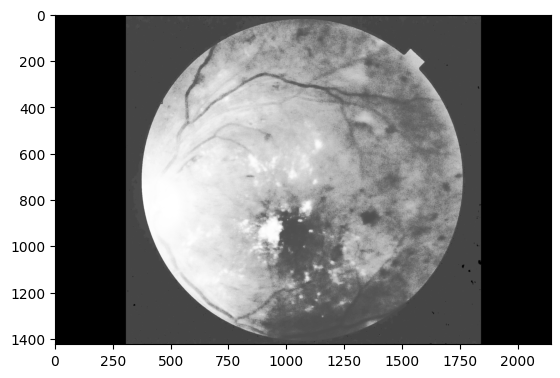

In [48]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[0].reshape((1424, 2144)), cmap='gray')
plt.show()

Performing Discrete_Wavelet transform on the 2-D array available

In [49]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((1424, 2144))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

Visualising a random image

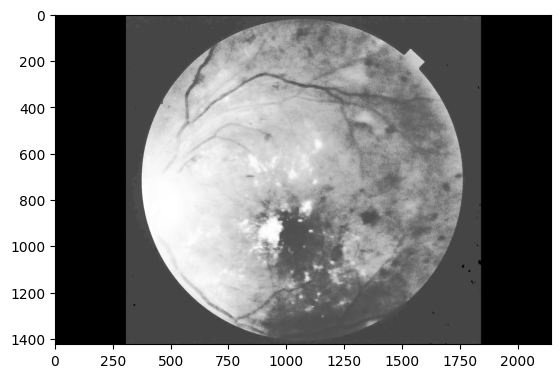

In [50]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[0].reshape((1424, 2144)), cmap='gray')
plt.show()

In [51]:
def show_images(images, titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)  # Make subplot
        if image.ndim == 2:  # Is image grayscale?
            plt.imshow(image, cmap=cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(),
                        dtype=np.float) * n_ims / scale)
    plt.show()

In [52]:
def _filter_kernel_mf_fdog(L, sigma, t=3, mf=True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')

    ctr_x = dim_x / 2
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate.
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)
    
    vectorized_k_fun = np.vectorize(k_fun, otypes=[np.float32])
    vectorized_k_fun_derivative = np.vectorize(k_fun_derivative, otypes=[np.float32])

    if mf:
        kernel = vectorized_k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = vectorized_k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1)


In [53]:
def gaussian_matched_filter_kernel(L, sigma, t=3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

In [54]:
def createMatchedFilterBank(K, n=12):
    '''
    Given a kernel, create matched filter bank
    '''
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

In [55]:
def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

In [56]:
gf = gaussian_matched_filter_kernel(15, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1424, 2144))
    equ3 = applyFilters(equ2, bank_gf)
    imm_gauss.append(np.array(equ3).flatten())


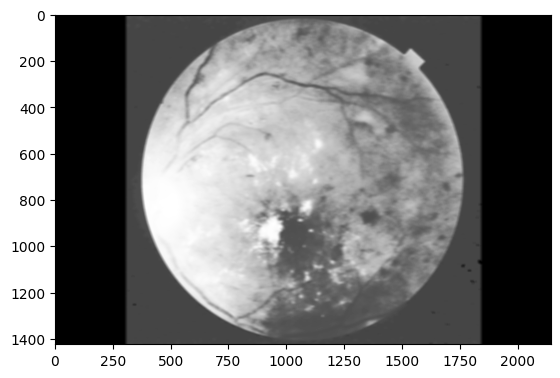

In [57]:
np.shape(imm_gauss)
plt.imshow(imm_gauss[0].reshape((1424, 2144)), cmap='gray')
plt.show()

In [58]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel(
            (ksize, ksize), 6, theta, 12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters


def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


bank_gf = createMatchedFilterBank()

imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1424, 2144))
    equ3 = applyFilters(equ2, bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


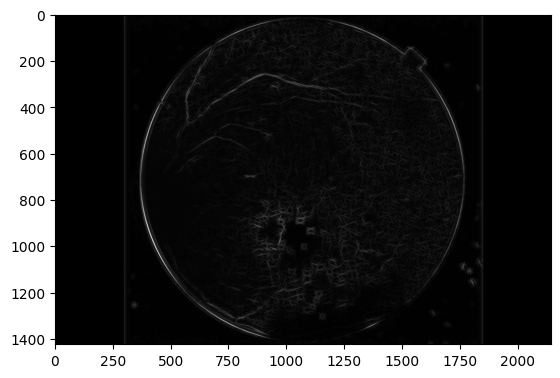

In [59]:
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[0].reshape((1424, 2144)), cmap='gray')
plt.show()

In [60]:
e_ = equ3
np.shape(e_)
e_ = e_.reshape((-1,6))
np.shape(e_)

ValueError: cannot reshape array of size 3053056 into shape (6)